## Step 2

Method to extract the parametres from the vdprm file using the forcefield.py script.

In [94]:
from collections import defaultdict
import matplotlib.pyplot as plt
import os
import glob
from pymol import cmd
import pandas as pd

In [3]:
from forcefield import VdwParamset

param_file = "data/vdwprm" #already given by github

paramset = VdwParamset(param_file) #load all parameters in a dictionary

vdw_sigma = { at: paramset.at_types[at].sig for at in paramset.at_types }
vdw_epsilon = { at: paramset.at_types[at].eps for at in paramset.at_types }
solv_sigma = { at: paramset.at_types[at].fsrf for at in paramset.at_types }

#Example of usage:
print(vdw_sigma["C"], vdw_epsilon["C"], solv_sigma["C"])
print(solv_sigma)

3.4 0.09 0.019
{'A': 0.111, 'C': 0.019, 'N': -0.124, 'P': 0.0, 'SA': 0.026, 'HO': 0.0, 'HD': 0.0, 'H': 0.0, 'OH': -0.043, 'OC': -0.069, 'OA': -0.031}


### Inter-chain Interaction Energies

In [4]:
import math
from Bio.PDB import PDBParser
from forcefield import VdwParamset, AtomType

#### Euclidean distance between two atoms

We need to compute the 3D distances that will be nedded for VdW and electrostatics.

In [5]:
def distance(coord1, coord2):
    return math.sqrt(
        (coord1[0]-coord2[0])**2 +
        (coord1[1]-coord2[1])**2 +
        (coord1[2]-coord2[2])**2
    )

#### VdW Energy

In [6]:
def autodock_oxygen_type(resname, atom_name): #to check if the atom is O and add the corresponding complement atom
    if resname in ("SER", "THR", "TYR", "HOH"):
        return "OH"
    if resname in ("ASP", "GLU"):
        return "OC"
    return "OA"
def autodock_hydrogen_type(atom_name):
    if atom_name == 'HN':
        return 'HD'

def vdw_energy(atom_type_i, atom_type_j, r, resname_i, resname_j):
    """
    uses combination rules:
        sigma_ij = (sigma_i + sigma_j)/2
        epsilon_ij = sqrt(epsilon_i * epsilon_j)
    """
    if r == 0:
        return 0
    #Check oxigens and hydorgens and sulfurs
    if atom_type_i == 'O':
        atom_type_i = autodock_oxygen_type(resname_i,atom_type_i)
    elif atom_type_i == 'HN' or atom_type_i == 'HC':
        atom_type_i = 'HD'
    elif atom_type_i == 'S':
        atom_type_i = 'SA'

    if atom_type_j == 'O':
        atom_type_j = autodock_oxygen_type(resname_j,atom_type_j)
    elif atom_type_j == 'HN' or atom_type_j == 'HC':
        atom_type_j = 'HD'
    elif atom_type_j == 'S':
        atom_type_j = 'SA'
        
    #print("ATOMS TYPES VAN DER WAALS: ", atom_type_j, atom_type_i)
    sigma_i = vdw_sigma[atom_type_i]
    sigma_j = vdw_sigma[atom_type_j]
    eps_i = vdw_epsilon[atom_type_i]
    eps_j = vdw_epsilon[atom_type_j]

    #Combinatorial rules
    sigma_ij = 0.5 * (sigma_i + sigma_j)
    eps_ij = math.sqrt(eps_i * eps_j)

    sr6 = (sigma_ij / r)**6
    sr12 = sr6 * sr6
    return 4 * eps_ij * (sr12 - sr6)

#### Mehler–Solmajer Dielectric

Reduces the electrostatic attraction as distance grows.

In [16]:
def mehler_solmajer_dielectric(r):
    cmp1 = 86.9525/(1 + 7.7839*math.exp(-0.3153 * r))
    return cmp1 - 8.5525

#### Electrostatic Energy

In [17]:
def electrostatic_energy(qi, qj, r):
    """
    Electrostatic energy: 332.16 * qi*qj / (epsilon_r * r)
    """
    if r == 0:
        return 0
    eps_r = mehler_solmajer_dielectric(r)
    return 332.16 * (qi * qj) / (eps_r * r)
    #return 332.16 * (qi * qj) / (eps_r)

**When reading the structure it is necessary to convert the simple name of the atom to only the symbol**

In [9]:
def get_element(atom_name):
    for a in atom_name:
        if a.isalpha():
            return a.upper()
    return None

### Solvation energy

In [10]:
def compute_solvation(file, selected_chains = None, interface_atoms = None):
    '''
        ∆𝐺 = ∑(𝜎𝑖 * ASAi) -> Formula to compute solvation energy
        ASA corresponds to the value obtained in the asa files after running naccess
        solvation parameter is obtained by using the solv_sigma dictionary obtained from the vdwprm

        file -> corresponds to asa file
        selected_chains -> are the chains between which we want to find the solvation as we want to find it first individually and then between both
        interface_atoms -> correspond to the atoms in the interface for the case when we compute solvation just for interface residues
    '''

       # Build lookup set from interface_atoms (once)
    interface_atoms_dict = None
    # we save all atoms in a list of dictionaries, so now we need to create a dictionary for all interface atoms
    if interface_atoms:
        interface_atoms_dict = {
            (a["chain"], int(a["resid"]), a["name"].strip())
            for a in interface_atoms
        }
    
    total_energy = 0.0
    solvation_residues = defaultdict(int)

    with open(file, "r") as f: #opening the asa file
        for line in f:
            if not line.startswith("ATOM") or not line:
                continue

            chain = line[21] #corresponding to the chain position
            resid = int(line[22:26])
            atom_name = line[12:16].strip()
            resname = line[17:20].strip()
            #filter chain
            if selected_chains and chain not in selected_chains:
                continue
            
            #Filter interface
            if interface_atoms_dict:
                key = (chain, resid, atom_name) 
                if key not in interface_atoms_dict:
                    continue

            el = get_element(atom_name) #get element based on atom name

            #Get asa value (2nd to last cols)
            cols = line.split()
            asa = float(cols[-2])

            asp = solv_sigma.get(el, 0.0)
            total_energy += asa*asp #corresponding to the formula

            #for keeping the solvation for each residue for later
            k = f"{chain}:{resname}{resid}"
            solvation_residues[k] += asa*asp
    
    return total_energy, solvation_residues



#### Load Atoms

The function reads the pdb preprocessed file and load the atoms. Needed to obtain the partial charges (important for electrostatics) and atom types (important for VdW).

In [11]:
def load_atoms_from_pdbqt(pdbqt_file):
    """
    Returns atoms with fields:
    name, type, charge, resname, resid, chain, coord
    """
    atoms = []
    with open(pdbqt_file) as f:
        for line in f:
            if not line.startswith("ATOM"):
                continue

            parts = line.split()
            atom_type = parts[-1]          # PDBQT atom type
            charge = float(parts[-2])      # partial charge

            atoms.append({
                "name": parts[2],
                "type": atom_type,
                "charge": charge,
                "resname": parts[3],
                "resid": int(parts[5]),
                "chain": parts[4],
                "coord": (float(parts[6]), float(parts[7]), float(parts[8]))
            })
    return atoms

#### Copute Interaction Energies Between Chains

In [18]:
def compute_interchain_energy(atoms, chainA="A", chainE="E"):
    atoms_A = [a for a in atoms if a["chain"] == chainA]
    atoms_E = [a for a in atoms if a["chain"] == chainE]

    total_vdw = 0.0
    total_elec = 0.0

    residue_vdw  = {}
    residue_elec = {}

    for ai in atoms_A:
        for ej in atoms_E:
            r = distance(ai["coord"],ej["coord"])
        
            vdw = vdw_energy(ai["type"], ej["type"], r, ai['resname'], ej['resname'])
            elec = electrostatic_energy(ai["charge"], ej["charge"], r)

            total_vdw  += vdw
            total_elec += elec

            # accumulate per residue
            resid_key = f"{ai['chain']}:{ai['resname']}{ai['resid']}"
            residue_vdw[resid_key]  = residue_vdw.get(resid_key, 0)  + vdw
            residue_elec[resid_key] = residue_elec.get(resid_key, 0) + elec

    return total_vdw, total_elec, residue_vdw, residue_elec

#### Usage

In [19]:
#input files
pdbqt = "data/6m0j_fixed_bo.pdbqt"
all_chains = "data/6m0j_fixed_bo.asa"
chainA_asa = "data/6m0j_fixed_chainA_bo.asa"
chainE_asa = "data/6m0j_fixed_chainE_bo.asa"

In [20]:
atoms = load_atoms_from_pdbqt(pdbqt)

total_vdw, total_elec, res_vdw, res_elec = compute_interchain_energy(atoms)
#Individual solvations
solv_A, resA_solv = compute_solvation(chainA_asa, selected_chains={'A'})
solv_E, resE_solv= compute_solvation(chainE_asa, selected_chains={'E'})

#Energy of interaction between each chain and the complex
solv_A_complex, resAcomplex_solv = compute_solvation(all_chains, selected_chains={'A'})
solv_E_complex, resEcomplex_solv = compute_solvation(all_chains, selected_chains={'E'})
interaction_solvation = (solv_A_complex + solv_E_complex) - (solv_A + solv_E)

complete_G = total_elec + total_vdw + interaction_solvation - solv_A - solv_E


In [21]:
#PRINTING RESULTS
print("COMPLETE INTERACTION ENERGY WITH ALL ATOMS")
print(f"VDW total:        {total_vdw:.3f} kcal/mol")
print(f"Electrostatics:   {total_elec:.3f} kcal/mol")
print(f"Solvation chain A isolated: {solv_A:.3f} kcal/mol")
print(f"Solvation chain E isolated: {solv_E:.3f} kcal/mol")
print(f"Solvation energy chain A and complex: {solv_A_complex:.3f} kcal/mol")
print(f"Solvation energy chain E and complex: {solv_E_complex:.3f} kcal/mol")
print(f"Solvation energy of the complete interaction: {interaction_solvation:.3f} kcal/mol")
print("=====================")
print("Complete ΔG = ", complete_G, "kcal/mol")
print()

'''print("Per Residue Contributions (Chain A)")
for res in sorted(res_vdw.keys()):
    print(f"{res:10s}  VDW={res_vdw[res]:.2f}  ELEC={res_elec[res]:.2f}")'''

COMPLETE INTERACTION ENERGY WITH ALL ATOMS
VDW total:        -86.874 kcal/mol
Electrostatics:   -23.893 kcal/mol
Solvation chain A isolated: -233.138 kcal/mol
Solvation chain E isolated: -88.003 kcal/mol
Solvation energy chain A and complex: -221.335 kcal/mol
Solvation energy chain E and complex: -83.522 kcal/mol
Solvation energy of the complete interaction: 16.285 kcal/mol
Complete ΔG =  226.6590933273535 kcal/mol



'print("Per Residue Contributions (Chain A)")\nfor res in sorted(res_vdw.keys()):\n    print(f"{res:10s}  VDW={res_vdw[res]:.2f}  ELEC={res_elec[res]:.2f}")'

### Getting the interface residues  
We run the `interacting_residues.py` file so we can compute the interacting energies only in the interface

In [23]:
from interacting_residues import interacting_residues
pdbqt_interchain = "data/interacting_residues_bo.pdbqt"
interacting_residues("data/6m0j_fixed_bo.pdbqt", 5.0, pdbqt_interchain)

In [24]:
#pdbqt_interchain = "data/interacting_residues.pdbqt"  
atoms_interchain = load_atoms_from_pdbqt(pdbqt_interchain)

total_vdw_inter, total_elec_inter, res_vdw_inter, res_elec_inter = compute_interchain_energy(atoms_interchain)

#Individual solvations
solv_A_inter, resA_solv_inter = compute_solvation(chainA_asa, selected_chains={'A'}, interface_atoms=atoms_interchain)
solv_E_inter, resE_solv_inter = compute_solvation(chainE_asa, selected_chains={'E'}, interface_atoms=atoms_interchain)

#Energy of interaction between each chain and the complex
solv_A_complex_inter, resAcomplex_solv_inter = compute_solvation(all_chains, selected_chains={'A'}, interface_atoms=atoms_interchain)
solv_E_complex_inter, resEcomplex_solv_inter = compute_solvation(all_chains, selected_chains={'E'}, interface_atoms=atoms_interchain)
interaction_solvation_interface = (solv_A_complex_inter + solv_E_complex_inter) - (solv_A_inter + solv_E_inter)

#This is just to keep the solvation for each interacting residue in the interface (plots)
solv_inter_complex, res_solv_complex = compute_solvation(all_chains, selected_chains={'A', 'E'}, interface_atoms=atoms_interchain)


complete_G_interface = total_elec_inter + total_vdw_inter + interaction_solvation_interface - solv_A_inter - solv_E_inter


In [25]:
#PRINTING RESULTS
print("=== INTERCHAIN INTERACTION ENERGY ===")
print(f"VDW total:        {total_vdw_inter:.3f} kcal/mol")
print(f"Electrostatics:   {total_elec_inter:.3f} kcal/mol")
print(f"Solvation chain A isolated: {solv_A_inter:.3f} kcal/mol")
print(f"Solvation chain E isolated: {solv_E_inter:.3f} kcal/mol")
print(f"Solvation energy chain A and complex: {solv_A_complex_inter:.3f} kcal/mol")
print(f"Solvation energy chain E and complex: {solv_E_complex_inter:.3f} kcal/mol")
print(f"Solvation energy of the complete interaction: {interaction_solvation_interface:.3f} kcal/mol")
print("=====================")
print("Complete ΔG for interface = ", complete_G_interface, "kcal/mol")
print("=====================================\n")


=== INTERCHAIN INTERACTION ENERGY ===
VDW total:        -70.596 kcal/mol
Electrostatics:   -17.404 kcal/mol
Solvation chain A isolated: -19.262 kcal/mol
Solvation chain E isolated: -5.687 kcal/mol
Solvation energy chain A and complex: -7.459 kcal/mol
Solvation energy chain E and complex: -1.206 kcal/mol
Solvation energy of the complete interaction: 16.285 kcal/mol
Complete ΔG for interface =  -46.765447858403256 kcal/mol



**Plotting interface residues energies**

61 30


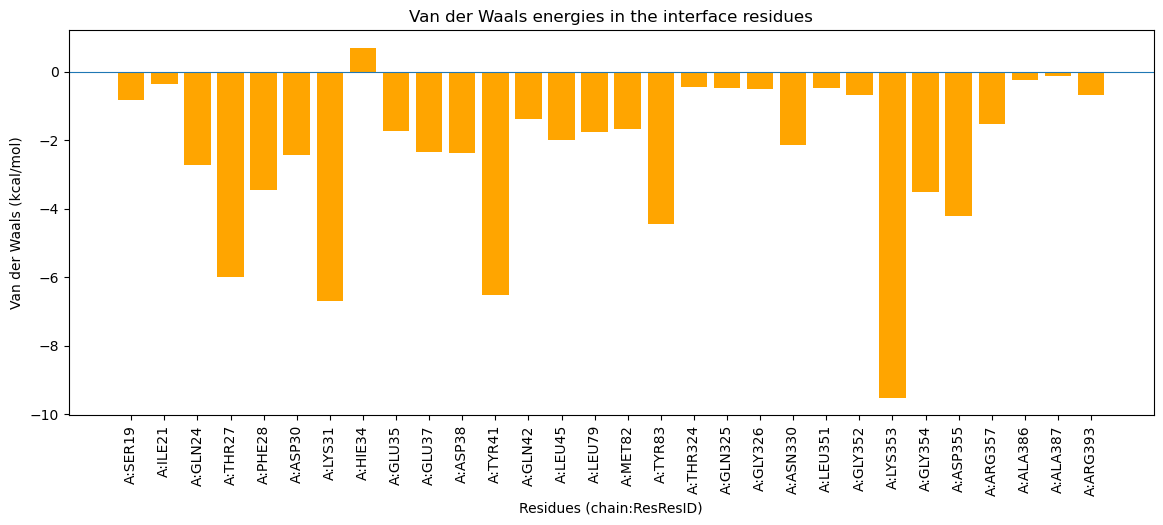

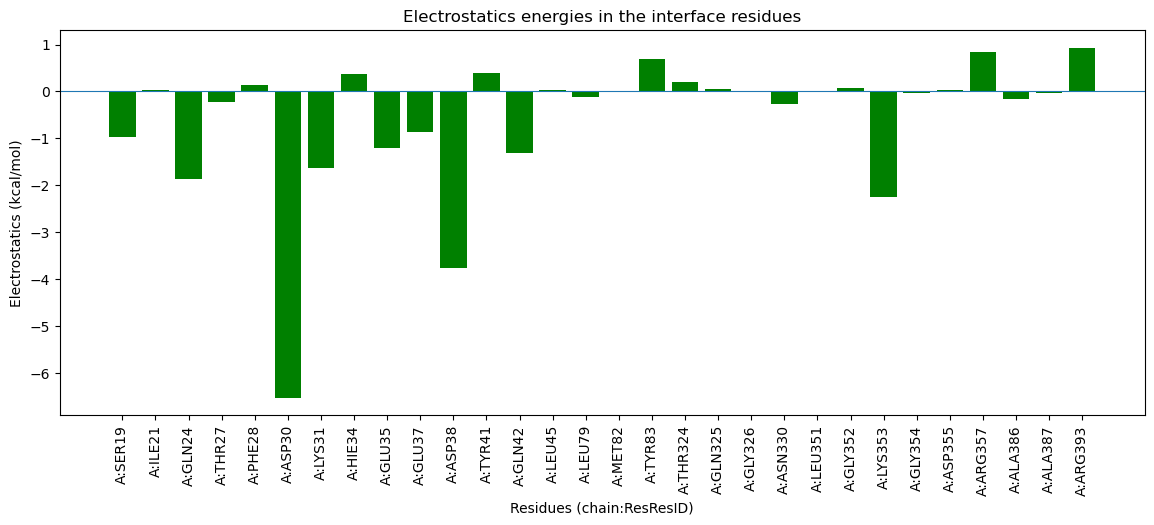

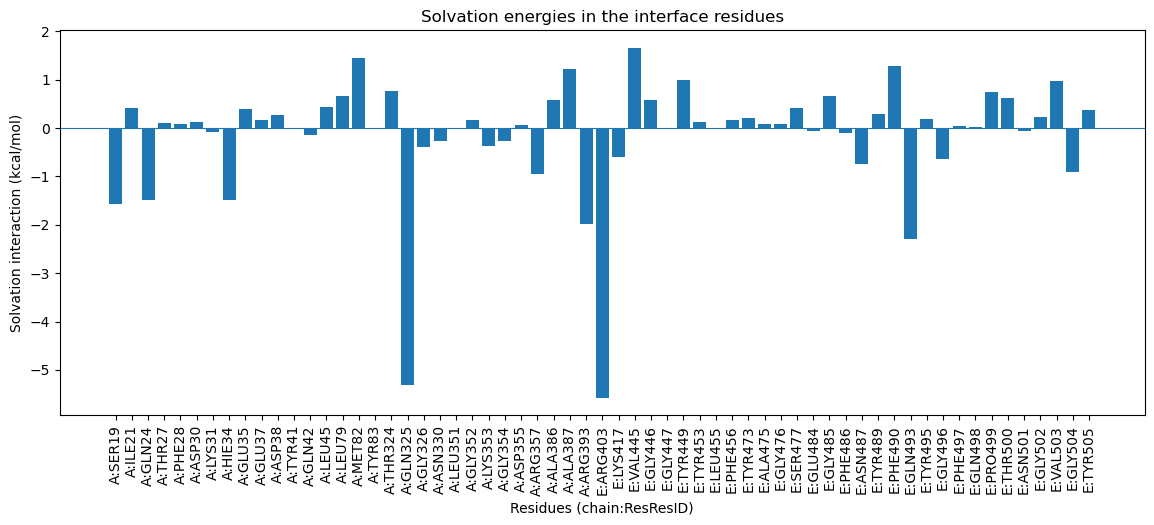

In [26]:
residues = res_vdw_inter.keys()
vdw_inter = res_vdw_inter.values()
elect_inter = res_elec_inter.values()
solv_inter = res_solv_complex.values()

plt.figure(figsize=(14, 5))
plt.bar(residues, vdw_inter, color = "orange")
plt.axhline(0, linewidth=0.8)
plt.xticks(rotation=90)
plt.ylabel("Van der Waals (kcal/mol)")
plt.xlabel("Residues (chain:ResResID)")
plt.title("Van der Waals energies in the interface residues")
plt.show()


plt.figure(figsize=(14, 5))
plt.bar(residues, elect_inter, color = "green")
plt.axhline(0, linewidth=0.8)
plt.xticks(rotation=90)
plt.ylabel("Electrostatics (kcal/mol)")
plt.xlabel("Residues (chain:ResResID)")
plt.title("Electrostatics energies in the interface residues")
plt.show()

solv_residues = res_solv_complex.keys()
plt.figure(figsize=(14, 5))
plt.bar(solv_residues, solv_inter)
plt.axhline(0, linewidth=0.8)
plt.xticks(rotation=90)
plt.ylabel("Solvation interaction (kcal/mol)")
plt.xlabel("Residues (chain:ResResID)")
plt.title("Solvation energies in the interface residues")
plt.show()

While plots for Van der Waals energies and Electrostatics, show 30 residues, as they show interaction between pairs of residues, plot for solvation energies, shows twice as many residues. This is because solvation is an energy that relates a residue with the solvent, not with another residue.

Making a counter to see how many amino acids of each type there are in the interface

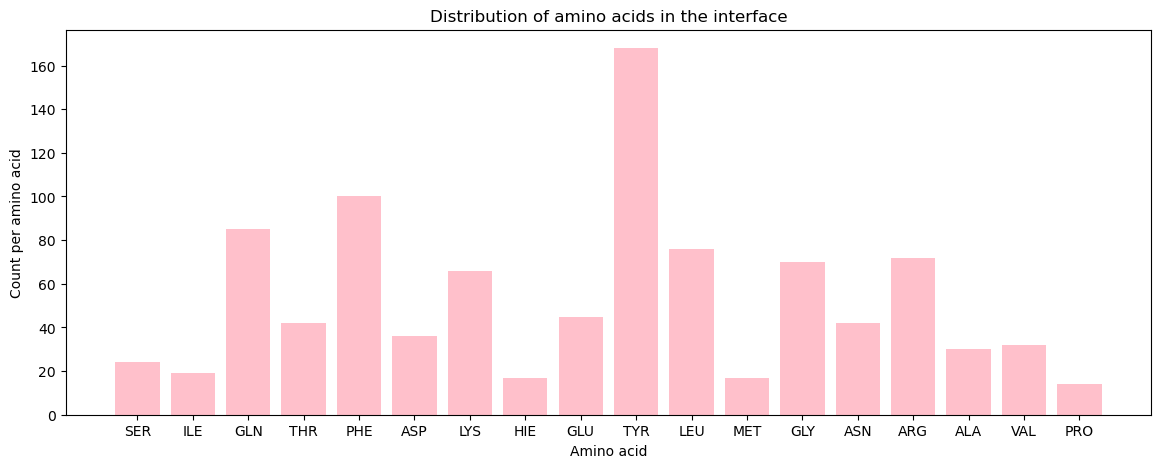

In [ ]:
res_interface = defaultdict(int) #dict working as a counter
for di in atoms_interchain:
    resname = di['resname']
    res_interface[resname] += 1
res_interface

plt.figure(figsize=(14, 5))
plt.bar(res_interface.keys(), res_interface.values(), color = "pink")
plt.ylabel("Count per amino acid")
plt.xlabel("Amino acid")
plt.title("Distribution of amino acids in the interface")
plt.show()

In [47]:
atoms_interchain


[{'name': 'N',
  'type': 'N',
  'charge': -0.664,
  'resname': 'SER',
  'resid': 19,
  'chain': 'A',
  'coord': (-31.455, 49.474, 2.505)},
 {'name': 'CA',
  'type': 'C',
  'charge': 0.14,
  'resname': 'SER',
  'resid': 19,
  'chain': 'A',
  'coord': (-31.359, 50.852, 2.04)},
 {'name': 'C',
  'type': 'C',
  'charge': 0.592,
  'resname': 'SER',
  'resid': 19,
  'chain': 'A',
  'coord': (-31.051, 50.892, 0.548)},
 {'name': 'O',
  'type': 'O',
  'charge': -0.578,
  'resname': 'SER',
  'resid': 19,
  'chain': 'A',
  'coord': (-31.921, 51.244, -0.251)},
 {'name': 'CB',
  'type': 'C',
  'charge': 0.112,
  'resname': 'SER',
  'resid': 19,
  'chain': 'A',
  'coord': (-30.297, 51.627, 2.826)},
 {'name': 'OG',
  'type': 'O',
  'charge': -0.594,
  'resname': 'SER',
  'resid': 19,
  'chain': 'A',
  'coord': (-30.882, 52.734, 3.49)},
 {'name': 'H1',
  'type': 'HN',
  'charge': 0.471,
  'resname': 'SER',
  'resid': 19,
  'chain': 'A',
  'coord': (-30.518, 48.968, 2.327)},
 {'name': 'H2',
  'type': 'H

# Alanine Scanning

In [79]:
from Bio.PDB import PDBParser, PDBIO
import copy
import os
import shutil

def replace_residue_with_ala(residue):
    """
    Replace a residue with Ala, keeping the base atoms (N, CA, C, O)
    and CB. Remove all other atoms of the current residue.
    Residues that are Glycine or already Alanine are skipped.
    """
    if residue.get_resname() == 'GLY' or residue.get_resname() == 'ALA':
        return False # Gly has no side chain beyond H, nothing to remove

    backbone_atoms = ['N', 'CA', 'C', 'O', 'CB']  # Keep CB for Ala
    for atom in list(residue.get_atoms()):
        if atom.get_name() not in backbone_atoms:
            residue.detach_child(atom.get_id())

    # Change residue name to ALA
    residue.resname = 'ALA'
    return True

In [109]:
def write_mutant_pdb(mutated_structure, output_file):
    '''
        To save the mutated structures in a pdb file so NACCESS works correctly
        mutated_structure: the structure with the current residue mutated
        output_file: the name of the mutated pdb file
    '''

    io = PDBIO()
    io.set_structure(mutated_structure)
    io.save(output_file)

In [86]:
def update_pdbqt_residues(input_pdbqt, mutated_structure, mutated_residue, mutated_residue_id, output_file):
    ''' 
        Function so we can keep the mutated structure in a pdbqt file so it is useful to compute then the energies
        input_pdbqt: pdbqt file to use as template (the original one)
        mutated_structure: the structure with the mutated residue by alanine
        mutated_residue_id: tuple (chain_id, resnum)
        mutated_residue: which is the residue that has been substituted by alanine
        output_file: file where the structure will be saved
    '''
    chain_id, res_id_tuple = mutated_residue_id
    mutant_res = mutated_structure[0][chain_id][res_id_tuple]

    #Saving atoms from the mutated residue with their coordinates
    dict_coordinates = {}
    for atom in mutant_res:
        dict_coordinates[atom.get_name()] = atom.get_coord()

    with open(input_pdbqt, 'r') as fin, open(output_file, 'w') as fout:
        for line in fin:
            if line.startswith('ATOM'):
                line_resnum = int(line[22:26].strip())
                line_chain = line[21].strip()
                line_atom = line[12:16].strip()
                
                #print(chain_id, mutated_residue.resname, [a.get_name() for a in mutated_residue])
                
                #check that the line corresponds to the one of the mutated residue
                if (line_chain==chain_id) and (line_resnum==res_id_tuple[1]):
                    if line_atom in dict_coordinates:
                        x,y,z = dict_coordinates[line_atom]

                        #updating coordinates in the output pdbqt
                        new_line = (line[:30] + f"{x:8.3f}{y:8.3f}{z:8.3f}" + line[54:])

                        fout.write(new_line)
                    continue

                #for the not mutated residues
                fout.write(line)


In [112]:
from Bio.PDB import PDBParser
#Load structure
parser = PDBParser(QUIET=True)
structure = parser.get_structure("interface", pdbqt_interchain)

output_dir = "ala_scanning"

#Removing if there's a currently existing directory for ala scanning
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

model = structure[0]
os.makedirs(output_dir, exist_ok=True)

#interating through each residue in the structure
for chain in model:
    for res in list(chain):

        #using deppcopy so we only mutated one residue at a time
        mutated_structure = copy.deepcopy(structure)
        mutated_res = mutated_structure[model.id][chain.id][res.id]
        if replace_residue_with_ala(mutated_res):
            #Save the structure mutated
            chain_id = chain.id
            resname = res.get_resname()
            resseq = res.id[1]
            output_file = os.path.join(output_dir, f"{chain_id}_{resname}{resseq}_ALA.pdbqt")
            output_pdb = os.path.join(output_dir, f"{chain_id}_{resname}{resseq}_ALA.pdb")

            write_mutant_pdb(mutated_structure, output_pdb)
            update_pdbqt_residues(pdbqt_interchain, mutated_structure, mutated_res, (chain.id, mutated_res.id), output_file)


Creating the PDBQT files for the chains separated

In [113]:
pdbqt_files = glob.glob(os.path.join(output_dir, "*.pdbqt"))
chain_A = 'A'
chain_E = 'E'
for pdbqt_file in pdbqt_files:
    base = os.path.splitext(os.path.basename(pdbqt_file))[0]
    # Load the pdbqt file into PyMOL
    cmd.reinitialize()  # clear PyMOL session
    cmd.load(pdbqt_file, "interface")

    # Select chain A and save
    cmd.select("chainA", f"interface and chain {chain_A}")
    output_A = os.path.join(output_dir, f"{base}_chain{chain_A}.pdb")
    cmd.save(output_A, "chainA")

    # Select chain E and save
    cmd.select("chainE", f"interface and chain {chain_E}")
    output_E = os.path.join(output_dir, f"{base}_chain{chain_E}.pdb")
    cmd.save(output_E, "chainE")

    #print(f"Processed {base}")


Running NACCESS in all the pdbqt files generated by the ala scanning

In [114]:
os.system('sh naccess_alascanning.sh')

naccess: using defualt vdw.radii
naccess: using default STD FILE
naccess: using defualt vdw.radii
naccess: using default STD FILE
naccess: using defualt vdw.radii
naccess: using default STD FILE
naccess: using defualt vdw.radii
naccess: using default STD FILE
naccess: using defualt vdw.radii
naccess: using default STD FILE
naccess: using defualt vdw.radii
naccess: using default STD FILE
naccess: using defualt vdw.radii
naccess: using default STD FILE
naccess: using defualt vdw.radii
naccess: using default STD FILE
naccess: using defualt vdw.radii
naccess: using default STD FILE
naccess: using defualt vdw.radii
naccess: using default STD FILE
naccess: using defualt vdw.radii
naccess: using default STD FILE
naccess: using defualt vdw.radii
naccess: using default STD FILE
naccess: using defualt vdw.radii
naccess: using default STD FILE
naccess: using defualt vdw.radii
naccess: using default STD FILE
naccess: using defualt vdw.radii
naccess: using default STD FILE
naccess: using defualt vd

0

In [115]:
def compute_energies_alascanning(pdbqt_file, asa_file, chainA_asa, chainE_asa, chainA_label="A", chainE_label = "E"):
    ''' 
        Computing all the corresponding energies (electrostatics, van der waals, solvation)
        the structures created by ala scanning.

        pdbqt_file: pdbqt file for the structure
        asa_file: asa file
        all_chains_asa: asa file from all chains
        chainA_label, chainE_label: chain ids for the interacting chains
    '''
    
    atoms_pdbqt = load_atoms_from_pdbqt(pdbqt_file)

    #coords = [atom for atom in atoms_pdbqt]
    #print(pdbqt_file, coords[:5])  # print first 5 atoms

    total_vdw_ala, total_elec_ala, res_vdw_ala, res_elec_ala = compute_interchain_energy(atoms_pdbqt)

    #Individual solvations
    solvA_ala, resA_solv_ala = compute_solvation(chainA_asa, selected_chains={chainA_label}, interface_atoms=atoms_pdbqt)
    solvE_ala, resE_solv_ala = compute_solvation(chainE_asa, selected_chains={chainE_label}, interface_atoms=atoms_pdbqt)

    #Energy of interaction between each chain and the complex
    solv_A_complex_ala, resAcomplex_solv_ala = compute_solvation(asa_file, selected_chains={chainA_label}, interface_atoms=atoms_pdbqt)
    solv_E_complex_ala, resEcomplex_solv_ala = compute_solvation(asa_file, selected_chains={chainE_label}, interface_atoms=atoms_pdbqt)
    interaction_solvation_ala = (solv_A_complex_ala + solv_E_complex_ala) - (solvA_ala + solvE_ala)

    #This is just to keep the solvation for each interacting residue in the interface (plots)
    #solv_inter_complex, res_solv_complex = compute_solvation(all_chains_asa, selected_chains={chainA_label, chainE_label}, interface_atoms=atoms_interchain)

    complete_G_ala = total_elec_ala + total_vdw_ala + interaction_solvation_ala - solvA_ala - solvE_ala
    delta_delta_G = complete_G_ala - complete_G_interface
    return {
        'vdw': total_vdw_ala,
        'elect': total_elec_ala,
        'solv_chainA': solvA_ala,
        'solv_chainE': solvE_ala,
        'solv_interact': interaction_solvation_ala,
        'tota_free_energy': complete_G_ala,
        'delta_delta_G': delta_delta_G
    }


In [116]:

energies_alascanning = {} #resulting dictionary with name of the mutant and energy values

ala_dir = "ala_scanning"

for pdbqt_file in glob.glob(os.path.join(ala_dir, "*.pdbqt")): #iterating over all the files in the folder
    base = os.path.splitext(os.path.basename(pdbqt_file))[0] #obtaining the part of the file name A_MET_ALA
    asa_file = os.path.join(ala_dir, f"{base}.asa")
    chainA_asa = os.path.join(ala_dir, f"{base}_chainA.asa")
    chainE_asa = os.path.join(ala_dir, f"{base}_chainE.asa")

    if not os.path.exists(asa_file):
        print(f"{base} FILE NOT FOUND, SKIPPING IT")
        continue

    energies = compute_energies_alascanning(pdbqt_file, asa_file, chainA_asa, chainE_asa)
    energies_alascanning[base] = energies
    

In [ ]:
'''for k in energies_alascanning:
    print(f"Residue: {k} with energies: {energies_alascanning[k]}")'''

Residue: A_GLU37_ALA with energies: {'vdw': -68.60159864698802, 'elect': -16.74634334718229, 'solv_chainA': -75.74713400000003, 'solv_chainE': -30.905760999999956, 'solv_interact': 17.39082900000001, 'tota_free_energy': 38.695782005829685}
Residue: E_PHE497_ALA with energies: {'vdw': -70.32041818739089, 'elect': -17.505724790414167, 'solv_chainA': -73.55492400000004, 'solv_chainE': -31.658122999999982, 'solv_interact': 16.284418000000016, 'tota_free_energy': 33.67132202219499}
Residue: E_SER477_ALA with energies: {'vdw': -70.4800586848071, 'elect': -17.7516688153348, 'solv_chainA': -73.55492400000004, 'solv_chainE': -30.63843499999995, 'solv_interact': 16.284541999999988, 'tota_free_energy': 32.24617349985808}
Residue: A_LYS31_ALA with energies: {'vdw': -66.42352849090285, 'elect': -16.23795023761746, 'solv_chainA': -70.25824300000002, 'solv_chainE': -30.905760999999956, 'solv_interact': 13.055437999999995, 'tota_free_energy': 31.557963271479665}
Residue: E_THR500_ALA with energies: {'

Converting the resulting dictionary in a data frame so we can plot the resulting energies to compare

In [118]:
df_ala = pd.DataFrame.from_dict(energies_alascanning, orient="index")
df_ala.index.name = "mutation"
df_ala.reset_index(inplace=True)
print(df_ala.head())

       mutation        vdw      elect  solv_chainA  solv_chainE  \
0   A_GLU37_ALA -68.601599 -16.746343   -75.747134   -30.905761   
1  E_PHE497_ALA -70.320418 -17.505725   -73.554924   -31.658123   
2  E_SER477_ALA -70.480059 -17.751669   -73.554924   -30.638435   
3   A_LYS31_ALA -66.423528 -16.237950   -70.258243   -30.905761   
4  E_THR500_ALA -68.359871 -18.180468   -73.554924   -30.911314   

   solv_interact  tota_free_energy  delta_delta_G  
0      17.390829         38.695782      85.461230  
1      16.284418         33.671322      80.436770  
2      16.284542         32.246173      79.011621  
3      13.055438         31.557963      78.323411  
4      15.802360         33.728259      80.493707  


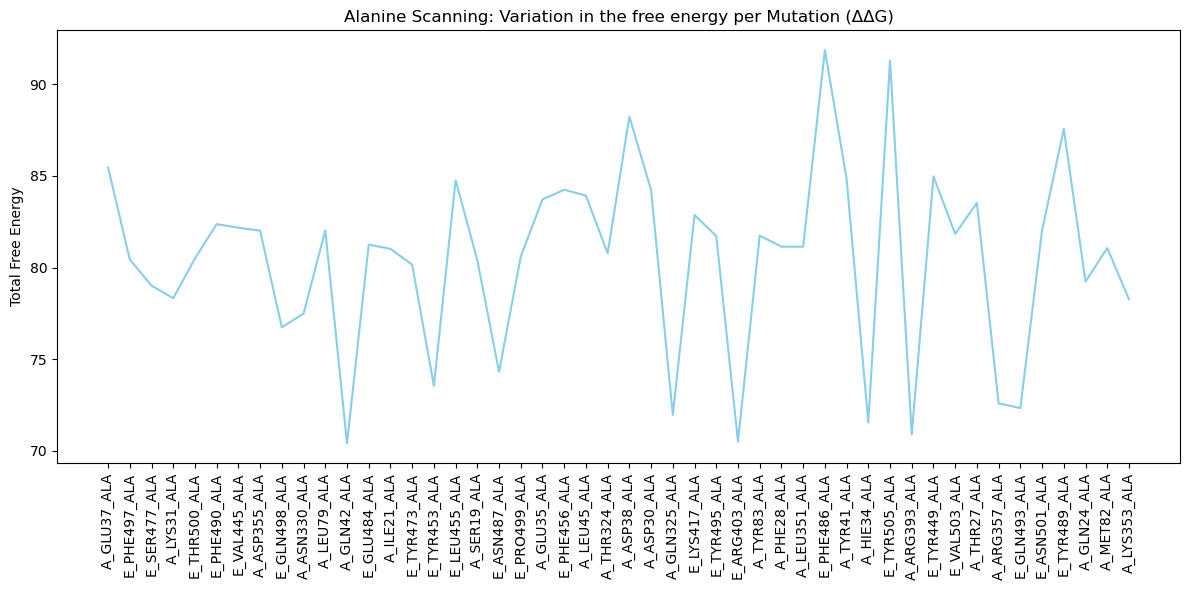

In [119]:
plt.figure(figsize=(12,6))
plt.plot(df_ala['mutation'], df_ala['delta_delta_G'], color='skyblue')
plt.xticks(rotation=90)  # rotate labels to fit
plt.ylabel("Total Free Energy")
plt.title("Alanine Scanning: Variation in the free energy per Mutation (ΔΔG)")
plt.tight_layout()
plt.show()

This plots shows a quick visualization of which mutations have the biggest variation in the free energy of the complex.

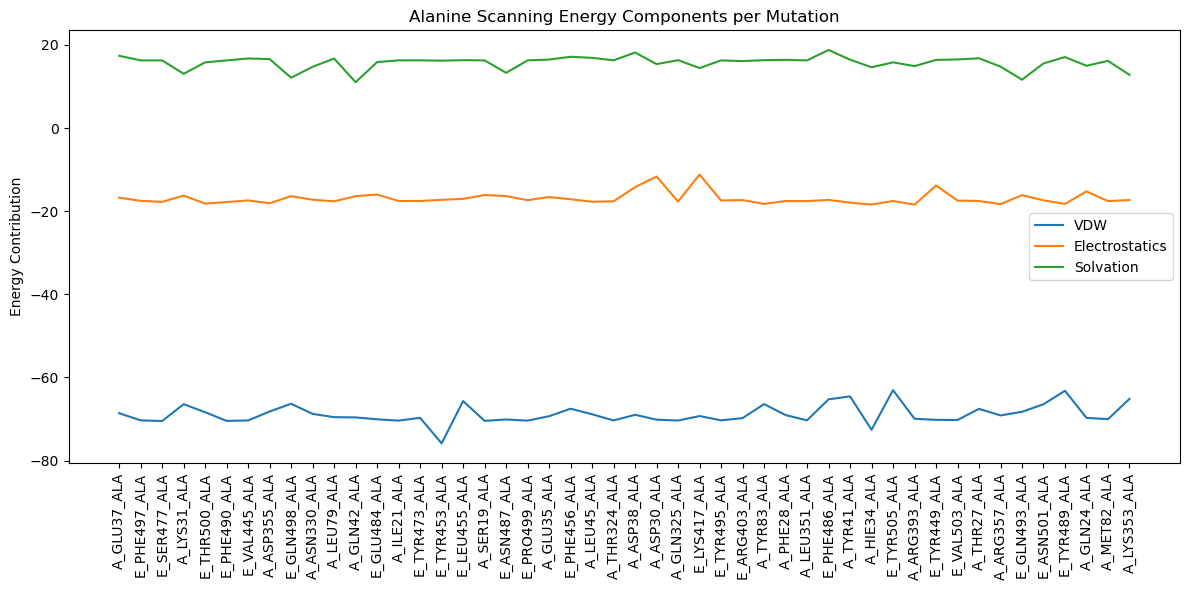

In [107]:
plt.figure(figsize=(12,6))
plt.plot(df_ala['mutation'], df_ala['vdw'], label='VDW')
plt.plot(df_ala['mutation'], df_ala['elect'], label='Electrostatics')
plt.plot(df_ala['mutation'], df_ala['solv_interact'], label='Solvation')
plt.xticks(rotation=90)
plt.ylabel("Energy Contribution")
plt.title("Alanine Scanning Energy Components per Mutation")
plt.legend()
plt.tight_layout()
plt.show()